# Final Project

In [ ]:
!pip install yellowbrick
!pip install prettytable

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import os
import numpy as np
from numpy import arange, absolute, mean
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import defaultdict
from IPython.display import Image
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_regression 
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from prettytable import PrettyTable
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection

In [ ]:
#os.chdir("/Users/jpzahn/Documents/FIFA Data")

In [ ]:
full_data = pd.read_csv("model_data.csv")
gk_df = pd.read_csv("gk_df.csv")
field_df = pd.read_csv("field_df.csv")

In [ ]:
#create goalkeeper dataframe by selecting players with corresponding position index
gk_df = full_data[full_data.position_dummy == 1]
gk_df = gk_df[["long_name","age", "height_cm", "weight_kg", "value_eur", "gk_diving", "gk_handling", "gk_kicking", "gk_reflexes", "gk_speed", "gk_positioning", "movement_acceleration", "movement_sprint_speed", "movement_agility", "movement_reactions", "movement_balance", "power_shot_power", "power_jumping", "power_stamina", "power_strength", "power_long_shots", "mentality_vision", "mentality_penalties", "mentality_composure", "number_of_traits"]]

In [ ]:
field_df = full_data[full_data.position_dummy != 1]
field_df = field_df.drop(["Unnamed: 0", "sofifa_id", "gk_diving", "gk_handling", "gk_kicking", "gk_reflexes", "gk_speed", "gk_positioning", "international_reputation", "position_dummy", "preferred_foot"],axis=1)

In [ ]:
#for later processing, create dictionaries containing players name/age and respective index in base dataframe
name_gk = list(gk_df.long_name)
index_gk = list(gk_df.index)
gk_zip_iter = zip(index_gk, name_gk)
gk_dict = dict(gk_zip_iter)

name_field = list(field_df.long_name)
index_field = list(field_df.index)
field_zip_iter = zip(index_field, name_field)
field_dict = dict(field_zip_iter)

In [ ]:
age_gk = list(gk_df.age)
gk_age_zip_iter = zip(index_gk, age_gk)
gk_age_dict = dict(gk_age_zip_iter)
gk_df= gk_df.drop(["long_name"], axis=1)

age_field = list(field_df.age)
field_age_zip_iter = zip(index_field, age_field)
field_age_dict = dict(field_age_zip_iter)
field_df = field_df.drop(["long_name"],axis = 1)

In [ ]:
gk_df = gk_df.astype(float)
field_df = field_df.astype(float)

## Regression

Linear regression most simple predictive model, by creating linear combination of independent features accounted for with a specific weight, finally predicting a dependent variable. Loss function to be minimized with OLS, sum of squared residuals. 

Linear regression might underfit, a model that is too sophisticated might overfit. Therefore, as previously introduced, regularizing a regression model is very suitable for a lot of scenarios. The overall technique is trying to reduce the variance of predictors by penalizing the coefficients of features when the corresponding value is too high, by reducing them and their impact on the dependent variable.

a) L1 (Lasso = Least Absolute Shrinkage and Selection Operator) Regularization

Lasso simultaneously regularizes and selects the features, therefore outputs a sparse model. Especially reasonable when multicollineartity is given in the data. Feature selection in that sense that features with a coefficient of 0 wont be considered forthgoing. By setting (normalize = True), automatically performs feature scaling.

The loss function (e.g. MSE) only considers absolute values of estimators, high ones are being penalized.

Danger --> correlation in the data will lead to one remaining feature, while the rest of coefficients will be 0. Possible data/information loss.

b) L2 (Ridge) Regularization

Ridge minimizes the loss function (MSE) by adding a penalty to the coefficient which corresponds to the coef-square plus a parameter (alpha) controlling the penalizing. However, contrarily to Lasso, does not reduce model complexity by not eliminating features (as nothing is set to 0 straight). Mostly leads to low variance and low bias, nearly always reduce overfitting. Parameter is chosen by cross- validation error. If parameter is 0, model will correspond to Linear Regression

Lasso regression can exclude useless variables from equation and it is a little better that ridge regression at reducing the variance in the models that contain a lot of useless variables In contrast, Ridge regression tends to do a little better when most variables are useful.

#### Scaling

An important note before applying the models: Usually, especially large datasets including variables of different value ranges and magnitudes require a transformation prior to the model-execution. The reason behind that is to achieve comparability between the variables themselves and therefore finally the ability for the applier to interpret the results in a correct way. In the case of the FIFA dataset however, due to the large data cleaning and the fact that the majority of the variables are per-se within a range of 1 to 99, this could be perceived as not necessary. However, due to the fact that regularization techniques are gonna be applied, scaling is necessary in this case. For Linear regression, scaling is performed equally for consistency reasons. 

In [ ]:
X_gk = gk_df.drop("value_eur",axis=1)
y_gk = gk_df.value_eur

X_field = field_df.drop("value_eur",axis=1)
y_field = field_df.value_eur

In [ ]:
X_gk_train, X_gk_test, y_gk_train, y_gk_test = train_test_split(X_gk, y_gk, test_size = (1/3), random_state = 42)
X_field_train, X_field_test, y_field_train, y_field_test = train_test_split(X_field, y_field, test_size = (1/3), random_state = 42)

This data will be used for Lasso and Ridge, as by setting (normalize = True), scaling is performed straight within the function. For LinReg scaling is not really necessary, but done for consistency reasons throughout the project. Store the scaled data in separate objects.

In [ ]:
gk_mms = MinMaxScaler()
X_gk_train_sc = gk_mms.fit_transform(X_gk_train)
X_gk_test_sc = gk_mms.transform(X_gk_test)

In [ ]:
field_mms = MinMaxScaler()
X_field_train_sc = field_mms.fit_transform(X_field_train)
X_field_test_sc = field_mms.transform(X_field_test)

In [ ]:
cols_gk = X_gk.columns
cols_field = X_field.columns

X_gk_train_sc = pd.DataFrame(X_gk_train_sc, columns = cols_gk)
X_gk_test_sc = pd.DataFrame(X_gk_test_sc, columns = cols_gk)
X_field_train_sc = pd.DataFrame(X_field_train_sc, columns = cols_field)
X_field_test_sc = pd.DataFrame(X_field_test_sc, columns = cols_field)

### a) Linear

In [ ]:
#create a linreg object for the goalkeeper dataset and fit it to the corresponding training data
reg_gk = LinearRegression()
reg_gk.fit(X_gk_train_sc, y_gk_train)

LinearRegression()

In [ ]:
reg_field = LinearRegression()
reg_field.fit(X_field_train_sc, y_field_train)

LinearRegression()

We want to perform a cross validation to see if the model is stable across different test data textures. 

Later, we will perform Repeated KFold cross validation for Ridge and Lasso regression, as both types require the optimization of its parameter. Therefore, the RKFold can be combined with a grid search for the hyperparameter tuning. For the linear model, the usual cross validation with KFold is sufficient.

In [ ]:
gk_linreg_folds = KFold(n_splits = 4, shuffle = True, random_state = 42)
field_linreg_folds = KFold(n_splits = 4, shuffle = True, random_state = 42)
gk_linreg_scores = cross_val_score(reg_gk, X_gk_train_sc, y_gk_train, scoring='r2', cv=gk_linreg_folds)
field_linreg_scores = cross_val_score(reg_field, X_field_train_sc, y_field_train, scoring="r2", cv=field_linreg_folds)

In [ ]:
gk_linreg_scores, field_linreg_scores

(array([0.96101712, 0.95974147, 0.95877214, 0.96238128]),
 array([0.86254557, 0.86302529, 0.86647665, 0.86573345]))

As we can observe, the model performance is stable in the case of both datasets. 

In [ ]:
#run the model on the test data for both datasets
y_pred_reg_gk = reg_gk.predict(X_gk_test_sc)
y_pred_reg_field = reg_field.predict(X_field_test_sc)

In [ ]:
#compare the model accuracy with R-squared on training and test data for both datasets
reg_rsq_gk_train = reg_gk.score(X_gk_train_sc, y_gk_train)
reg_rsq_field_train = reg_field.score(X_field_train_sc, y_field_train)
reg_rsq_gk_test = reg_gk.score(X_gk_test_sc, y_gk_test)
reg_rsq_field_test = reg_field.score(X_field_test_sc, y_field_test)

In [ ]:
reg_rsq_gk_train, reg_rsq_field_train

(0.9621644918911548, 0.8656386348496493)

In [ ]:
reg_rsq_gk_test, reg_rsq_field_test

(0.9571310311949068, 0.8630962170998951)

In [ ]:
#compute evaluation metrics MSE, RMSE, MAE and MAPE for model execution on both datasets
mse_linreg_gk = mean_squared_error(y_gk_test, y_pred_reg_gk, squared = True)
rmse_linreg_gk = mean_squared_error(y_gk_test, y_pred_reg_gk, squared = False)

mse_linreg_field = mean_squared_error(y_field_test, y_pred_reg_field, squared = True)
rmse_linreg_field = mean_squared_error(y_field_test, y_pred_reg_field, squared = False)

mae_linreg_gk = mean_absolute_error(y_gk_test, y_pred_reg_gk)
mape_linreg_gk = mean_absolute_percentage_error(y_gk_test, y_pred_reg_gk)

mae_linreg_field = mean_absolute_error(y_field_test, y_pred_reg_field)
mape_linreg_field = mean_absolute_percentage_error(y_field_test, y_pred_reg_field)

In [ ]:
mse_linreg_gk, mse_linreg_field

(0.0925917853456644, 0.25553688236164723)

In [ ]:
rmse_linreg_gk, rmse_linreg_field

(0.30428898328014503, 0.5055065601568858)

In [ ]:
mae_linreg_gk, mae_linreg_field

(0.23871987458619756, 0.40202271820396157)

In [ ]:
mape_linreg_gk, mape_linreg_field

(0.018645381070779215, 0.02986229231318895)

An important evaluation criterion is the distribution of the residuals of the regression. Therefore, we want to display a histogram for both datasets. A good indicator of a well-fitting modedl is a normal distribution centered around 0.

#### Evaluation of residuals

(array([ 8., 22., 21., 46., 66., 77., 97., 71., 86., 57., 42., 31., 19.,
        20.,  4.,  5.,  6.,  2.,  4.,  1.]),
 array([-0.68520263, -0.5939698 , -0.50273696, -0.41150413, -0.3202713 ,
        -0.22903846, -0.13780563, -0.0465728 ,  0.04466004,  0.13589287,
         0.2271257 ,  0.31835854,  0.40959137,  0.5008242 ,  0.59205704,
         0.68328987,  0.7745227 ,  0.86575554,  0.95698837,  1.0482212 ,
         1.13945403]),
 <BarContainer object of 20 artists>)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


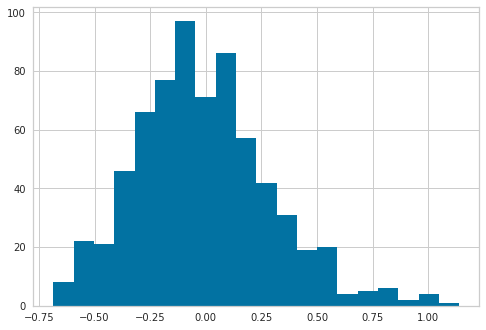

In [ ]:
plt.hist(y_pred_reg_gk - y_gk_test,bins=20)

(array([  1.,   1.,   7.,   8.,  28.,  61., 100., 193., 357., 470., 646.,
        721., 768., 691., 598., 389., 238., 143.,  75.,  29.,  17.,   8.,
          1.,   0.,   1.]),
 array([-2.10350149, -1.9303027 , -1.75710391, -1.58390512, -1.41070633,
        -1.23750754, -1.06430874, -0.89110995, -0.71791116, -0.54471237,
        -0.37151358, -0.19831478, -0.02511599,  0.1480828 ,  0.32128159,
         0.49448038,  0.66767917,  0.84087797,  1.01407676,  1.18727555,
         1.36047434,  1.53367313,  1.70687193,  1.88007072,  2.05326951,
         2.2264683 ]),
 <BarContainer object of 25 artists>)

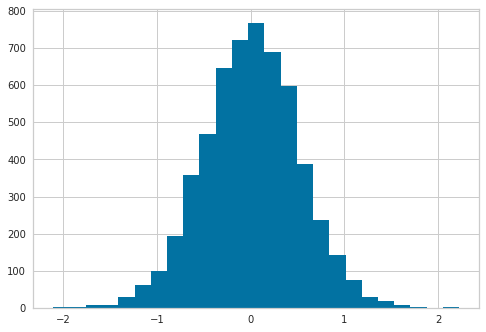

In [ ]:
plt.hist(y_pred_reg_field - y_field_test,bins=25)

We can see that both histograms follow a distribution that resembles a normal distribution, while the fieldplayer dataset residuals are almost perfectly normally distributed. The goalkeeper residuals are a little bit heavy tailed on the left and right side, but this is not perceived as serious issue.

A common principle within machine learning algorithms is feature selection, which allows the user to reduce the complexity of the model by only selecting those variables which correspond to a high importance for the target variable. Due to the fact that regularization techniques will be executed afterwards, this is to be neglected. Regularization achieves a similar outcome by modifying the features coefficients and based on that account for their importance.

### b) Lasso

We now perform a first possible regularization approach. Theory has been previously introduced. The execution process of the model itself is similar to the linear regression model, therefore we dispense further commentation as for now. 

We do not need to perform feature selection at this point, as Lasso does this on its own. 

In order to maximize the power of the model, we perform some tests on the data in order to receive the optimal value for the parameter alpha.

α can take various values:

1) α = 0:
The objective becomes same as simple linear regression.
We’ll get the same coefficients as simple linear regression.

2) α = ∞:
The coefficients will be zero. Because of infinite weightage on absolute value of coefficients, anything less than zero will make the objective infinite.

3) 0 < α < ∞:
The magnitude of α will decide the weightage given to different parts of objective.
The coefficients will be somewhere between 0 and ones for simple linear regression.

Since MAE is an error metric, i.e. the lower the better, negative MAE is the opposite: a value of -2.6 is better than a value of -3.0.



In [ ]:
lasso_gk = linear_model.Lasso(alpha=1, max_iter=10000, normalize = True)
lasso_field = linear_model.Lasso(alpha=1, max_iter=10000, normalize=True)

 Perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error

#### Goalkeeper Data

In [ ]:
lassocv_gk = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv_gk.fit(X_gk_train, y_gk_train)

#set the parameter chosen by lassocv
lasso_gk.set_params(alpha=lassocv_gk.alpha_)

#fit the model with the alpha chosen by LassoCv
lasso_gk.fit(X_gk_train, y_gk_train)

y_gk_pred_lasso = lasso_gk.predict(X_gk_test)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
Chosen alpha by tuning for goalkeeper data: 0.0001565416637330503


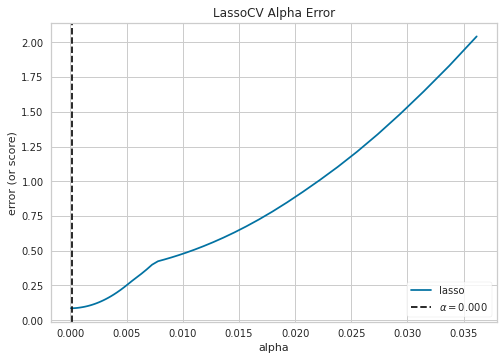

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [ ]:
visualizer_lassogk = AlphaSelection(lassocv_gk)
visualizer_lassogk.fit(X_gk_train, y_gk_train)
print("Chosen alpha by tuning for goalkeeper data:", lasso_gk.alpha)
visualizer_lassogk.show()

In [ ]:
pd.Series(lasso_gk.coef_, index=X_gk.columns)

age                     -0.113085
height_cm                0.002403
weight_kg                0.000000
gk_diving                0.047677
gk_handling              0.044879
gk_kicking               0.000000
gk_reflexes              0.053840
gk_speed                 0.000000
gk_positioning           0.038451
movement_acceleration    0.002393
movement_sprint_speed    0.000000
movement_agility        -0.000119
movement_reactions       0.021639
movement_balance        -0.000000
power_shot_power         0.012670
power_jumping            0.000000
power_stamina            0.000686
power_strength           0.000207
power_long_shots         0.000000
mentality_vision         0.000023
mentality_penalties      0.000000
mentality_composure     -0.000622
number_of_traits         0.000000
dtype: float64

The feature coefficients of lasso nicely visualize exactly which features are being considered by the model and which ones are being discarded by penalization leading to coefficients equal to 0. For instance, the weight, kicking, movement_sprint_speed, movement_balance, power_jumping or the penalty_mentality and the number of traits of a goalkeeper received a parameter equal to 0. 

In [ ]:
lasso_rsq_gk_train = lasso_gk.score(X_gk_train, y_gk_train)
lasso_rsq_gk_test = lasso_gk.score(X_gk_test, y_gk_test)
mse_lasso_gk = mean_squared_error(y_gk_test,y_gk_pred_lasso,squared=True)
rmse_lasso_gk = mean_squared_error(y_gk_test,y_gk_pred_lasso,squared=False)
mae_lasso_gk = mean_absolute_error(y_gk_test,y_gk_pred_lasso)
mape_lasso_gk = mean_absolute_percentage_error(y_gk_test,y_gk_pred_lasso)

In [ ]:
lasso_rsq_gk_train,lasso_rsq_gk_test

(0.9618928088829595, 0.9575696087332664)

In [ ]:
mse_lasso_gk, rmse_lasso_gk, mae_lasso_gk, mape_lasso_gk

(0.09164451093200053,
 0.3027284442070162,
 0.23513397579968337,
 0.018358710405164257)

#### Fieldplayer Data

In [ ]:
lassocv_field = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv_field.fit(X_field_train, y_field_train)

#set the parameter chosen by lassocv
lasso_field.set_params(alpha=lassocv_field.alpha_)

#fit the model with the alpha chosen by LassoCv
lasso_field.fit(X_field_train, y_field_train)

y_field_pred_lasso = lasso_field.predict(X_field_test)

Chosen alpha by tuning for fieldplayer data: 1.0626202237829496e-05


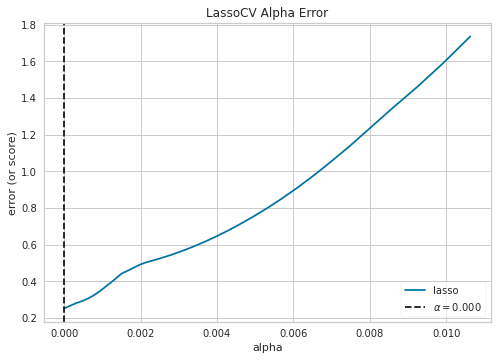

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [ ]:
visualizer_lassofield = AlphaSelection(lassocv_field)
visualizer_lassofield.fit(X_field_train, y_field_train)
print("Chosen alpha by tuning for fieldplayer data:",lasso_field.alpha)
visualizer_lassofield.show()

In [ ]:
lasso_rsq_field_train = lasso_field.score(X_field_train, y_field_train)
lasso_rsq_field_test = lasso_field.score(X_field_test, y_field_test)
mse_lasso_field = mean_squared_error(y_field_test,y_field_pred_lasso,squared=True)
rmse_lasso_field = mean_squared_error(y_field_test,y_field_pred_lasso,squared=False)
mae_lasso_field = mean_absolute_error(y_field_test,y_field_pred_lasso)
mape_lasso_field = mean_absolute_percentage_error(y_field_test,y_field_pred_lasso)

In [ ]:
pd.Series(lasso_field.coef_, index=X_field.columns)

age                          -0.072513
height_cm                    -0.002187
weight_kg                     0.006291
weak_foot                    -0.007871
skill_moves                   0.175433
pace                          0.000280
shooting                      0.000000
passing                       0.000000
dribbling                     0.000000
defending                     0.014673
physic                        0.001958
attacking_crossing            0.005650
attacking_finishing           0.006793
attacking_heading_accuracy    0.015375
attacking_short_passing       0.022325
attacking_volleys            -0.001388
skill_dribbling               0.006644
skill_curve                  -0.001500
skill_fk_accuracy            -0.000946
skill_long_passing           -0.004482
skill_ball_control            0.031290
movement_acceleration         0.010249
movement_sprint_speed         0.007661
movement_agility             -0.003807
movement_reactions            0.058107
movement_balance         

The coefficients again show exactly which features were "victimized" by a penalty, leading to 0 coefficient-values (for instance mentality_aggression, defending_standing_tacke and defending_sliding_tackle).

In [ ]:
lasso_rsq_field_train,lasso_rsq_field_test

(0.8653966490102939, 0.86331109490705)

In [ ]:
mse_lasso_field, rmse_lasso_field, mae_lasso_field, mape_lasso_field

(0.2551358035618807,
 0.5051096945831477,
 0.4015536813194801,
 0.02983133216967913)

(array([ 7., 13., 13., 21., 36., 52., 61., 67., 79., 57., 74., 56., 33.,
        34., 24., 16., 11.,  9.,  5.,  4.,  3.,  3.,  2.,  3.,  2.]),
 array([-0.68849877, -0.61535762, -0.54221647, -0.46907533, -0.39593418,
        -0.32279303, -0.24965189, -0.17651074, -0.1033696 , -0.03022845,
         0.0429127 ,  0.11605384,  0.18919499,  0.26233614,  0.33547728,
         0.40861843,  0.48175958,  0.55490072,  0.62804187,  0.70118302,
         0.77432416,  0.84746531,  0.92060646,  0.9937476 ,  1.06688875,
         1.1400299 ]),
 <BarContainer object of 25 artists>)

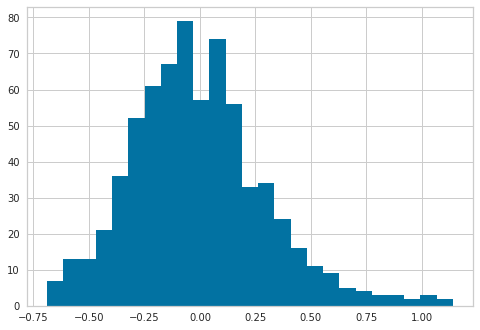

In [ ]:
plt.hist(y_gk_pred_lasso - y_gk_test,bins=25)

(array([  1.,   2.,   6.,  13.,  25.,  58., 104., 201., 361., 465., 653.,
        707., 768., 667., 610., 396., 239., 143.,  70.,  35.,  19.,   3.,
          4.,   0.,   1.]),
 array([-2.08645787, -1.91451607, -1.74257428, -1.57063249, -1.3986907 ,
        -1.22674891, -1.05480712, -0.88286533, -0.71092353, -0.53898174,
        -0.36703995, -0.19509816, -0.02315637,  0.14878542,  0.32072722,
         0.49266901,  0.6646108 ,  0.83655259,  1.00849438,  1.18043617,
         1.35237797,  1.52431976,  1.69626155,  1.86820334,  2.04014513,
         2.21208692]),
 <BarContainer object of 25 artists>)

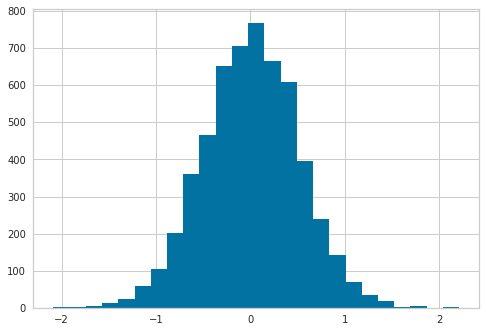

In [ ]:
plt.hist(y_field_pred_lasso - y_field_test,bins=25)

The residuals of the goalkeeper data after performing Lasso Regularization appear to be heavier on the left (negative) side, than on the right one. Contrarily, the fieldplayer data residuals appear to have the shape of a normal distribution.

### c) Ridge

Instead of arbitrarily choosing alpha  , it would be better to use cross-validation to choose the tuning parameter alpha. We can do this using the cross-validated ridge regression function, RidgeCV(). By default, the function performs generalized cross-validation , though this can be changed using the argument cv.

In [ ]:
alphas = np.logspace(-3, -1, 30)

In [ ]:
ridgecv_gk = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv_gk.fit(X_gk_train, y_gk_train)

RidgeCV(alphas=array([0.001     , 0.0011721 , 0.00137382, 0.00161026, 0.00188739,
       0.00221222, 0.00259294, 0.0030392 , 0.00356225, 0.00417532,
       0.0048939 , 0.00573615, 0.00672336, 0.00788046, 0.00923671,
       0.01082637, 0.01268961, 0.01487352, 0.01743329, 0.0204336 ,
       0.02395027, 0.02807216, 0.03290345, 0.0385662 , 0.04520354,
       0.05298317, 0.06210169, 0.07278954, 0.08531679, 0.1       ]),
        normalize=True, scoring='neg_mean_squared_error')

In [ ]:
ridge_gk = Ridge(alpha = ridgecv_gk.alpha_, normalize = True)
ridge_gk.fit(X_gk_train, y_gk_train)

y_gk_pred_ridge = ridge_gk.predict(X_gk_test)
print("Chosen alpha by tuning for goalkeeper data:",ridge_gk.alpha)

Chosen alpha by tuning for goalkeeper data: 0.0041753189365604


In [ ]:
pd.Series(ridge_gk.coef_, index = X_gk.columns)

age                     -0.114658
height_cm                0.003146
weight_kg                0.000091
gk_diving                0.047166
gk_handling              0.045501
gk_kicking               0.004075
gk_reflexes              0.053322
gk_speed                -0.001692
gk_positioning           0.038767
movement_acceleration    0.004345
movement_sprint_speed    0.000487
movement_agility        -0.001320
movement_reactions       0.022266
movement_balance        -0.000144
power_shot_power         0.007954
power_jumping            0.000375
power_stamina            0.001220
power_strength           0.000505
power_long_shots         0.000924
mentality_vision         0.000647
mentality_penalties     -0.000021
mentality_composure     -0.001761
number_of_traits         0.003363
dtype: float64

The coefficients give insight on how the different features are penalized or not. After performing ridge regression, a lot of coefficients are very very mall (for instance mentality_penalties, movement_sprint_speed or the weight of a goalkeeper (might be confusing from a neutral perspective). 

Contrarily, for instance the age is considered with a comparably high negative influence on the target variable, as well as the reflexes, handling, and diving appear to be evaluated as important.

In [ ]:
ridge_rsq_gk_train = ridge_gk.score(X_gk_train, y_gk_train)
ridge_rsq_gk_test = ridge_gk.score(X_gk_test, y_gk_test)
mse_ridge_gk = mean_squared_error(y_gk_test,y_gk_pred_ridge,squared=True)
rmse_ridge_gk = mean_squared_error(y_gk_test,y_gk_pred_ridge,squared=False)
mae_ridge_gk = mean_absolute_error(y_gk_test,y_gk_pred_ridge)
mape_ridge_gk = mean_absolute_percentage_error(y_gk_test,y_gk_pred_ridge)

In [ ]:
ridge_rsq_gk_train, ridge_rsq_gk_test

(0.962131320599537, 0.9572467461758396)

In [ ]:
mse_ridge_gk, rmse_ridge_gk, mae_ridge_gk, mape_ridge_gk

(0.09234185498870817,
 0.30387802649864004,
 0.23783065990928953,
 0.01857707064821874)

In [ ]:
ridgecv_field = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv_field.fit(X_field_train, y_field_train)

RidgeCV(alphas=array([0.001     , 0.0011721 , 0.00137382, 0.00161026, 0.00188739,
       0.00221222, 0.00259294, 0.0030392 , 0.00356225, 0.00417532,
       0.0048939 , 0.00573615, 0.00672336, 0.00788046, 0.00923671,
       0.01082637, 0.01268961, 0.01487352, 0.01743329, 0.0204336 ,
       0.02395027, 0.02807216, 0.03290345, 0.0385662 , 0.04520354,
       0.05298317, 0.06210169, 0.07278954, 0.08531679, 0.1       ]),
        normalize=True, scoring='neg_mean_squared_error')

In [ ]:
ridge_field = Ridge(alpha = ridgecv_field.alpha_, normalize = True)
ridge_field.fit(X_field_train, y_field_train)

y_field_pred_ridge = ridge_field.predict(X_field_test)
print("Chosen alpha by tuning for fieldplayer data:",ridge_field.alpha)

Chosen alpha by tuning for fieldplayer data: 0.001


In [ ]:
pd.Series(ridge_field.coef_, index = X_field.columns)

age                          -0.073025
height_cm                    -0.003539
weight_kg                     0.006705
weak_foot                    -0.009947
skill_moves                   0.177829
pace                          0.001927
shooting                      0.006295
passing                       0.003838
dribbling                    -0.004619
defending                     0.018064
physic                       -0.005032
attacking_crossing            0.005308
attacking_finishing           0.004683
attacking_heading_accuracy    0.014943
attacking_short_passing       0.021496
attacking_volleys            -0.002122
skill_dribbling               0.009443
skill_curve                  -0.001978
skill_fk_accuracy            -0.001181
skill_long_passing           -0.005486
skill_ball_control            0.032355
movement_acceleration         0.009777
movement_sprint_speed         0.006650
movement_agility             -0.003718
movement_reactions            0.058162
movement_balance         

By elaborating on the feature coefficients, the penalization of ridge regression can be visualized nicely. A lot of the features receive scores with very small values, where 3 or 4 decimal places equal zero. The features with a comparably higher score are being perceived as "important" by the model (no matter if the coefficient is negative or positive). 

In [ ]:
ridge_rsq_field_train = ridge_field.score(X_field_train, y_field_train)
ridge_rsq_field_test = ridge_field.score(X_field_test, y_field_test)
mse_ridge_field = mean_squared_error(y_field_test,y_field_pred_ridge,squared=True)
rmse_ridge_field = mean_squared_error(y_field_test,y_field_pred_ridge,squared=False)
mae_ridge_field = mean_absolute_error(y_gk_test,y_gk_pred_ridge)
mape_ridge_field = mean_absolute_percentage_error(y_gk_test,y_gk_pred_ridge)

In [ ]:
ridge_rsq_field_train, ridge_rsq_field_test

(0.8655783871913986, 0.8630732980210306)

In [ ]:
mse_ridge_field, rmse_ridge_field, mae_ridge_field, mape_ridge_field

(0.25557966182205055,
 0.505548871843317,
 0.23783065990928953,
 0.01857707064821874)

(array([ 8., 10., 17., 17., 39., 44., 66., 63., 80., 55., 71., 60., 33.,
        34., 23., 20., 10., 14.,  3.,  5.,  4.,  2.,  3.,  3.,  1.]),
 array([-0.69486307, -0.62202202, -0.54918096, -0.47633991, -0.40349885,
        -0.3306578 , -0.25781675, -0.18497569, -0.11213464, -0.03929359,
         0.03354747,  0.10638852,  0.17922957,  0.25207063,  0.32491168,
         0.39775273,  0.47059379,  0.54343484,  0.61627589,  0.68911695,
         0.761958  ,  0.83479906,  0.90764011,  0.98048116,  1.05332222,
         1.12616327]),
 <BarContainer object of 25 artists>)

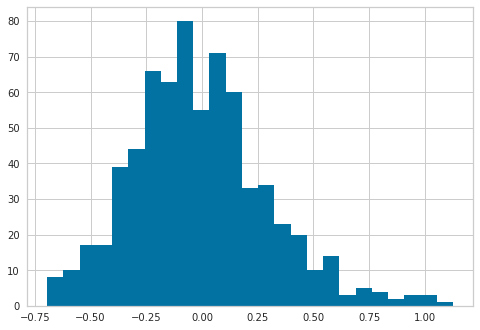

In [ ]:
plt.hist(y_gk_pred_ridge - y_gk_test,bins=25)

(array([  1.,   1.,   6.,   9.,  29.,  59., 104., 196., 359., 473., 652.,
        717., 773., 676., 603., 391., 231., 145.,  70.,  29.,  19.,   6.,
          1.,   0.,   1.]),
 array([-2.10133778, -1.92796613, -1.75459447, -1.58122282, -1.40785117,
        -1.23447951, -1.06110786, -0.88773621, -0.71436456, -0.5409929 ,
        -0.36762125, -0.1942496 , -0.02087795,  0.15249371,  0.32586536,
         0.49923701,  0.67260867,  0.84598032,  1.01935197,  1.19272362,
         1.36609528,  1.53946693,  1.71283858,  1.88621023,  2.05958189,
         2.23295354]),
 <BarContainer object of 25 artists>)

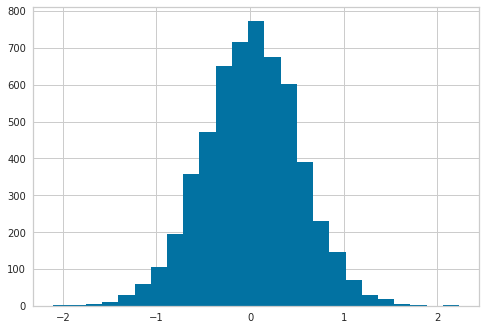

In [ ]:
plt.hist( y_field_pred_ridge - y_field_test,bins=25)

Similarly to Lasso and LinReg, the residuals of the fieldplayer data appears to be quite normally distributed, which is perceived as promising factor. The goalkeeper data again appears to have more heavy tails on both sides, but the distribution in total is centered around 0 as well.

#### Match predictions to players

Now, an exploration of the final scenario by matching the model results with the players themselves is executed. This requires another set of processing steps.

In [ ]:
#create a list containing the predicted values for both datasets, rounded to two decimal values
#values can be traced back by its index
gk_predictions = list(y_pred_reg_gk)
gk_predictions = [ '%.2f' % elem for elem in gk_predictions ]

field_predictions = list(y_pred_reg_field)
field_predictions = [ '%.2f' % elem for elem in field_predictions ]

In [ ]:
#the data in the test data after the split is unsorted. store the indexes in lists for both scenarios
#store the actual true market values in lists, the order is the same
index_gk_unsorted = list(y_gk_test.index)
gk_true = list(y_gk_test)
gk_true = [ '%.2f' % elem for elem in gk_true ]

index_field_unsorted = list(y_field_test.index)
field_true = list(y_field_test)
field_true = [ '%.2f' % elem for elem in field_true ]

In [ ]:
#zip all three lists together for both scenarios
list_total_gk = list(zip(index_gk_unsorted, gk_true, gk_predictions))
list_total_field = list(zip(index_field_unsorted, field_true, field_predictions))

In [ ]:
#create a dataframe from those lists for both scenarios
df_gk = pd.DataFrame(list_total_gk, columns = ['indexes', 'true', 'pred'])
df_gk.pred = df_gk.pred.astype(float)
df_gk.true = df_gk.true.astype(float)

df_field = pd.DataFrame(list_total_field, columns = ['indexes', 'true', 'pred'])
df_field.pred = df_field.pred.astype(float)
df_field.true = df_field.true.astype(float)

In [ ]:
#n additionally compare the difference in percentage between actual and predicted market value
df_gk["diff in %"] = ((df_gk.pred - df_gk.true) / df_gk.pred) * 100
df_gk["diff in %"] = df_gk['diff in %'].round(2)
df_field["diff in %"] = ((df_field.pred - df_field.true) / df_field.pred) * 100
df_field["diff in %"] = df_field['diff in %'].round(2)

In [ ]:
#we access the previously created dictionaries containing player and base index and extract those player
#which were present in the test data
#result is stored in another list in both scenarios
name_list_gk = []
age_list_gk = []
for index in df_gk.indexes:
    if index in gk_dict and index in gk_age_dict:
        name_list_gk.append(gk_dict[index])
        age_list_gk.append(gk_age_dict[index])
    else:
        break

In [ ]:
len(name_list_gk), len(age_list_gk)

(685, 685)

In [ ]:
name_list_field = []
age_list_field = []
for index in df_field.indexes:
    if index in field_dict and index in field_age_dict:
        name_list_field.append(field_dict[index])
        age_list_field.append(field_age_dict[index])
    else:
        break

In [ ]:
len(name_list_field), len(age_list_field)

(5551, 5551)

In [ ]:
#we add those lists to the dataframe
df_gk['player'] = name_list_gk
col_gk = df_gk.pop("player")
df_gk.insert(0, col_gk.name, col_gk)
df_gk['age'] = age_list_gk
col1_gk = df_gk.pop('age').astype(int)
#df_gk.insert(1, col1_gk.age, col1_gk)#
df_gk.insert(loc=1, column='age', value=col1_gk)

df_field['player'] = name_list_field
col_field = df_field.pop("player")
df_field.insert(0, col_field.name, col_field)
df_field['age'] = age_list_field
col1_field = df_field.pop('age').astype(int)
df_field.insert(loc=1, column='age', value=col1_field)

Now, we are ready to display the result for now. However, to be accounted for is the fact that the data is still transformed through the logarithm. It needs to be re-transformed in order to finally interpret the results correctly.

In [ ]:
#df_gk.sort_values(by='true',ascending=False)

In [ ]:
#df_field.sort_values(by='true',ascending=False)

#### Backtransform the data --> Exponential

According to the previous statement, we now eliminate the logarithm again from the target variable by applying the exponential function. Afterwards we will perform some further data cleaning, before we finally calculate percentage and absolute difference of the predicted and actual values.

In [ ]:
df_gk_org = df_gk[["player","age","indexes","true","pred"]]
df_gk_org.true = np.exp(df_gk_org.true)
df_gk_org.pred = np.exp(df_gk_org.pred)
#df_gk_org[df_gk_org.pred == np.inf]
#df_gk_org.true.replace([np.inf, -np.inf], 0, inplace=True)
#df_gk_org.pred.replace([np.inf, -np.inf], 0, inplace=True)
df_gk_org = df_gk_org[df_gk_org.true!= 0]
df_gk_org.true = df_gk_org.true.astype(int)
df_gk_org.pred = df_gk_org.pred.astype(int)
df_gk_org["diff_total"] = df_gk_org.pred - df_gk_org.true
df_gk_org["diff_%"] = ((df_gk_org.pred - df_gk_org.true) / df_gk_org.true) * 100

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_field_org = df_field[["player","age","indexes","true","pred"]]
df_field_org.true = np.exp(df_field_org.true)
df_field_org.pred = np.exp(df_field_org.pred)
#df_field_org[df_field_org.pred == np.inf]
#df_field_org.true.replace([np.inf, -np.inf], 0, inplace=True)
#df_field_org.pred.replace([np.inf, -np.inf], 0, inplace=True)
df_field_org = df_field_org[df_field_org.true!= 0]
df_field_org.true = df_field_org.true.astype(int)
df_field_org.pred = df_field_org.pred.astype(int)
df_field_org["diff_total"] = df_field_org.pred - df_field_org.true
df_field_org["diff_%"] = ((df_field_org.pred - df_field_org.true) / df_field_org.true) * 100

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
#avg_diff_perc_gk = df_gk_org["Difference in %"].mean()
avg_diff_abs_gk = df_gk_org["diff_total"].mean()
#avg_diff_perc_gk
round(avg_diff_abs_gk,2)

-47647.24

In [ ]:
#avg_diff_perc_field = df_field_org["Difference in %"].mean()
avg_diff_abs_field = df_field_org["diff_total"].mean()
#avg_diff_perc_field
round(avg_diff_abs_field,2)

-357922.35

As we can see, the model performs better on the goalkeeper dataset than on the field-player dataset. This is however no surprise, as we have much less columns and much less variation in the data. 

Overall, the model performs very good for both data sets, as the average difference in percent is very low!

### Display Measures

In [ ]:
mse_all_gk = [mse_linreg_gk, mse_lasso_gk, mse_ridge_gk]
rmse_all_gk = [rmse_linreg_gk, rmse_lasso_gk, rmse_ridge_gk]
mae_all_gk = [mae_linreg_gk, mae_lasso_gk, mae_ridge_gk]
mape_all_gk = [mape_linreg_gk, mape_lasso_gk, mape_ridge_gk]
mse_all_gk = [round(num, 3) for num in mse_all_gk]
rmse_all_gk = [round(num, 3) for num in rmse_all_gk]
mae_all_gk = [round(num, 3) for num in mae_all_gk]
mape_all_gk = [round(num, 3) for num in mape_all_gk]

mse_all_field = [mse_linreg_field, mse_lasso_field, mse_ridge_field]
rmse_all_field = [rmse_linreg_field, rmse_lasso_field, rmse_ridge_field]
mae_all_field = [mae_linreg_field, mae_lasso_field, mae_ridge_field]
mape_all_field = [mape_linreg_field, mape_lasso_field, mape_ridge_field]
mse_all_field = [round(num, 3) for num in mse_all_field]
rmse_all_field = [round(num, 3) for num in rmse_all_field]
mae_all_field = [round(num, 3) for num in mae_all_field]
mape_all_field = [round(num, 3) for num in mape_all_field]

In [ ]:
rsq_train_all_gk = [reg_rsq_gk_train, lasso_rsq_gk_train, ridge_rsq_gk_train]
rsq_train_all_field = [reg_rsq_field_train, lasso_rsq_field_train, ridge_rsq_field_train]
rsq_train_all_gk = [round(num, 3) for num in rsq_train_all_gk]
rsq_train_all_field = [round(num, 3) for num in rsq_train_all_field]

rsq_test_all_gk = [reg_rsq_gk_test, lasso_rsq_gk_test, ridge_rsq_gk_test]
rsq_test_all_field = [reg_rsq_field_test, lasso_rsq_field_test, ridge_rsq_field_test]
rsq_test_all_gk = [round(num, 3) for num in rsq_test_all_gk]
rsq_test_all_field = [round(num, 3) for num in rsq_test_all_field]

In [ ]:
method = ["Linear", "Lasso (L1)", "Ridge (L2)"]

In [ ]:
overview_gk = PrettyTable()
overview_gk.add_column('Method', method)
overview_gk.add_column("MSE", mse_all_gk)
overview_gk.add_column("RMSE", rmse_all_gk)
overview_gk.add_column("MAE", mae_all_gk)
overview_gk.add_column("MAPE", mape_all_gk)
overview_gk.add_column("R-squared", rsq_test_all_gk)

overview_field = PrettyTable()
overview_field.add_column('Method', method)
overview_field.add_column("MSE", mse_all_field)
overview_field.add_column("RMSE", rmse_all_field)
overview_field.add_column("MAE", mae_all_field)
overview_field.add_column("MAPE", mape_all_field)
overview_field.add_column("R-squared", rsq_test_all_field)

In [ ]:
print(overview_gk)

+------------+-------+-------+-------+-------+-----------+
|   Method   |  MSE  |  RMSE |  MAE  |  MAPE | R-squared |
+------------+-------+-------+-------+-------+-----------+
|   Linear   | 0.093 | 0.304 | 0.239 | 0.019 |   0.957   |
| Lasso (L1) | 0.092 | 0.303 | 0.235 | 0.018 |   0.958   |
| Ridge (L2) | 0.092 | 0.304 | 0.238 | 0.019 |   0.957   |
+------------+-------+-------+-------+-------+-----------+


In [ ]:
print(overview_field)

+------------+-------+-------+-------+-------+-----------+
|   Method   |  MSE  |  RMSE |  MAE  |  MAPE | R-squared |
+------------+-------+-------+-------+-------+-----------+
|   Linear   | 0.256 | 0.506 | 0.402 |  0.03 |   0.863   |
| Lasso (L1) | 0.255 | 0.505 | 0.402 |  0.03 |   0.863   |
| Ridge (L2) | 0.256 | 0.506 | 0.238 | 0.019 |   0.863   |
+------------+-------+-------+-------+-------+-----------+


## Analysis

One fact one has to consider before running linear regression models is implied by the model-name itself. Not every dataset, or in other words not many datasets, can be described with a linear relationship and require therefore a more complex theoretical "equation". This limits the scope of application of a comparable models and represents a major drawback in comparison to other machine learning algorithms such as RandomForests or Neural Networks, which are able to handle non-linear relationships in the data. Exactly this is also the reason for the log-transformation in case of this model, in order to receive a linear development of the logged target variables.

As we can see from the metrics tables above, the overall performance difference between our three main regression models (Linear, Lasso, Ridge) is only by marginal nature. This confirms the insights we were describing before. The effects of a regularization process depends on the used alpha-parameter. In our case, for the goalkeeper data the by the function chosen alpha-value was close to 0 (0.00015 and 0.004) which results in no penalty on the feature scores. For the fieldplayer data, the alpha mostly was 0.001 and 0.00001. Therefore, we can conclude that the regularization does not have an remarkable effect on the model performance, and a linear regression fulfils the job of predicting football player market values well on its own. However, this is a decision which is based on simplicity reasons. If the circumstances would differ, a regularization technique could be much more useful for a final interpretation of results. 

Remarkable is the fact that for the fieldplayer data, ridge regression performs better according to the absolute error metrics, however not in case of the squared ones. 

Overall we conclude that the normal linear regression is suitable for finally analyzing the market value differences between real values and our model. However, without considering and running the other models in this project, one could guess that the other models could outperform the linear regression model.

In [ ]:
df_gk_final_perc = df_gk_org.nlargest(100,'diff_%')
df_gk_final_total = df_gk_org.nlargest(100,"diff_total")
list_gk_topperc = list(df_gk_final_perc.player)
df_gk_final = df_gk_final_total[df_gk_final_total.player.isin(list_gk_topperc)]
df_gk_final["Position"] = "GK"

df_field_final_perc = df_field_org.nlargest(1000,'diff_%')
df_field_final_total = df_field_org.nlargest(1000,"diff_total")
list_field_topperc = list(df_field_final_perc.player)
df_field_final = df_field_final_total[df_field_final_total.player.isin(list_field_topperc)]
df_field_final["Position"] = "FP"

final = df_gk_final.append(df_field_final, ignore_index=True)
final[(final.age <= 23) & (final.true >= 1000000)].sort_values(by="diff_total",ascending=False)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,player,age,indexes,true,pred,diff_total,diff_%,Position
59,Everton Jorge Simão Resende,20,868,10019061,25906384,15887323,61.325899,FP
2,Lucas Luciano Mantela Patrício,20,1135,6990062,13256519,6266457,47.270758,GK
66,Silas Wamangituka,20,4447,3204286,6851649,3647363,53.233360,FP
67,Nuno Miguel Valente Santos,21,5361,1706576,5336070,3629494,68.018111,FP
69,Dani de Wit,22,5504,1397226,4876800,3479574,71.349532,FP
...,...,...,...,...,...,...,...,...
375,Damil Dankerlui,23,6469,1099097,1758549,659452,37.499780,FP
373,Joel Asoro,21,8376,1099097,1758549,659452,37.499780,FP
376,Bryan Ignacio Carabalí Cañola,22,6538,1099097,1758549,659452,37.499780,FP
20,Álvaro Vallés Rosa,22,6378,1004499,1498537,494038,32.968021,GK


In order to interpret the final dataframe for goalkeepers, one can perceive that Alisson Becker (goalkeeper of Liverpool FC, recently transferred for a huge amount of money), is strongly undervalued after our regression model. The total value difference of almost 30 million Euros is also considered high-ranked among the percentage difference. 

The second clearly undervalued goalkeeper is Andre Onana, who is perceived as huge talent by football experts.  
A drawback which can be perceived after analyzing the percentage difference between value derived from FIFA and the predicted values by regressiom is the fact that the players with the highest percentage difference are all very old. This could be a hint that the model is not entirely able to account for the importance of the age of a football player for the market value. However, the value range also needs to be accounted for, as the market values of the old players are anyway very low and a certain error has higher impact on the percentage difference as for players with values in the millions range.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d0001f84-164c-454a-9f8a-a2e6174a5f5c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>